# Load the Dataset

In [1]:
!kaggle datasets download -d sixhky/open-images-bus-trucks -p ./Dataset
!unzip ./Dataset/open-images-bus-trucks.zip -d ./Dataset

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./Dataset/open-images-bus-trucks.zip
replace ./Dataset/df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Import Libraries

In [2]:
from torchvision import transforms, models, datasets
from torchvision.ops import nms # Non-Maximum Suppression
from torch_snippets import *
from torch_snippets.torch_loader import Report

# Set the device

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# read the csv file

In [8]:
import pandas as pd
image_root_directory = './Dataset/images/images'
Raw_Information = pd.read_csv('./Dataset/df.csv')
Raw_Information.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


# define a custom dataset class

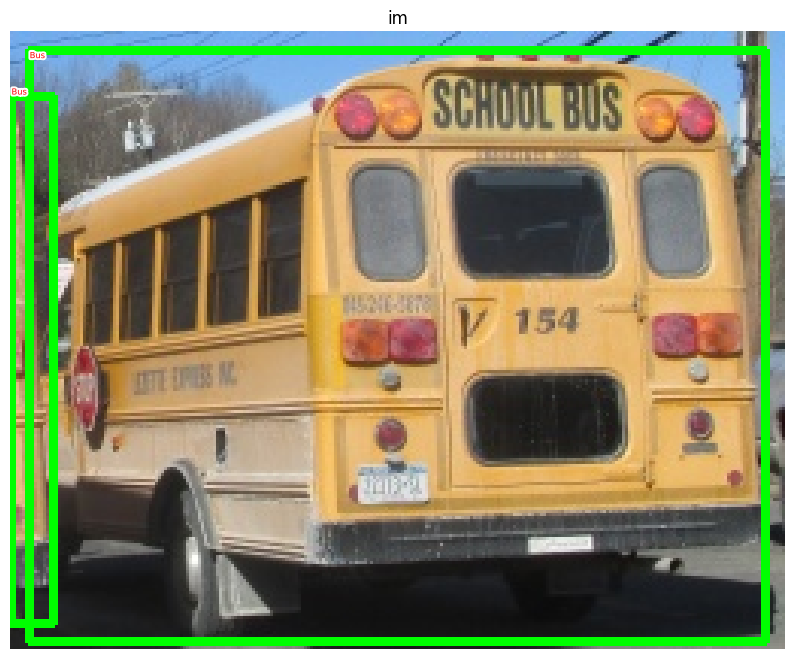

In [18]:
import cv2
from torch.utils.data import Dataset

class custom_dataset(Dataset):
    def __init__(self, dataframe, image_folder_root : str = image_root_directory):
        """
        A custom dataset class for loading images, labels, and bounding boxes from a CSV file and image folder.


       Args:
        dataframe (pandas.DataFrame): A DataFrame containing the metadata for the dataset, 
            including image filenames, labels, and bounding box coordinates ('XMin', 'YMin', 'XMax', 'YMax').
        image_folder_root (str): The root directory where the image files are stored. The file paths 
            in the DataFrame should be relative to this root.
        
        Returns:
                image (np.ndarray): The image corresponding to the given index, read and converted from BGR to RGB.
                image_boxes (list of list): A list of bounding box coordinates in the format [XMin, YMin, XMax, YMax].
                    The coordinates are scaled to the image dimensions.
                image_classes (list): label of bounding boxes in the image.
                path2image (str): The file path to the image.
        """
        self.root = image_folder_root
        self.df = dataframe
        self.images = dataframe['ImageID'].unique()
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_id = self.images[idx]
        path2image = f'{self.root}/{image_id}.jpg'
        # we need to convert format of the read image from BGR to RGB in cv2
        image = cv2.imread(path2image, # path 2 the image
                           1 # color format of BGR
                           ) [...,::-1]  # ... -->  all rows and columns  while ::-1 --> reverse the order of the last axis from BRG to RGB
        hight, width,_ = image.shape
        # The copy() method is a built-in method of pandas DataFrame and Series objects. It creates a copy of the object and is unrelated to Python's copy module.
        image_inf = self.df.copy() 
        # extract information of the image
        image_inf = image_inf[image_inf['ImageID'] == image_id]
        image_boxes = image_inf['XMin,YMin,XMax,YMax'.split(',')].values
       
        image_boxes = (image_boxes * np.array([width,hight,width,hight])).astype(np.uint16).tolist()
        image_classes = image_inf['LabelName'].values.tolist()
        return image, image_boxes, image_classes, path2image
        
# sample image
sample = custom_dataset(dataframe = Raw_Information)
random_image_idx = np.random.randint(0, len(sample))
im, bbs, clss,_ = sample[random_image_idx]
show(im, bbs = bbs, texts = clss, sz = 10)

In [ ]:
# define extracting IOU and candidate boxes
import selectivesearch
def extract_candidate_boxes (input_img):
    label, regions =  selectivesearch.selective_search(input_img, scale = 200, min_size = 100)
    area = np.prod(input_img.shape[:2]) # H, W, C
    candidates= []
    for region in regions:
        # choose candidate region that has over 5% of the total image area and less than or equal to 100% of the image area
        # This is an entry in each dictionary within the regions list that specifies the bounding box of the region. It typically contains four values: (x, y, width, height) that define the rectangle that bounds the region.
        if region['rect'] in candidates:  # do not choose repeated candidate region
            continue
        if region['size'] < (0.05 * area): # do not choose candidate region that has less than 5% cover of the  image
            continue
        if region['size'] > (1*area): # do not choose candidate region which is larger than the size of the image
            continue
        # x, y, w, h = region['rect']
        candidates.append(list(region['rect']))
    return 

def extract_iou (boxA, boxB, epsilon = 1e-6):
    x_min = max(boxA[0], boxB[0])
    y_min = max(boxA[1], boxB[1])
    x_max = min (boxA[2], boxB[2])
    y_max = max(boxA[3], boxB[3])
    width = (x_max - x_min)
    height = (y_max - y_min)
    
    if (width < 0) or (height < 0):
        return 0
    intersection_area = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = area_a + area_b - intersection_area
    iou = intersection_area / (union_area + epsilon)
    return iou